In [1]:
%matplotlib inline
import heartpy as hp
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"  # allows multiple prints from a cell
from IPython.display import display
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os, plotly.express as px, xgboost as xgb, re
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
from tqdm.notebook import tqdm
import json

# Import 3rd party libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Import local Libraries
from feature_extraction.features.feature_extractor import Features
from feature_extraction.utils.plotting.waveforms import plot_waveforms

os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.set_printoptions(linewidth=10000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_colwidth', 1000, 'display.max_columns', 20, 'display.width', 10000, 'display.max_rows', 8)

In [2]:
data_df = pd.read_csv("task_1/train/train_gts.csv")
meta_df = pd.read_csv("task_1/train/train_meta.csv")
test_meta_df = pd.read_csv("task_1/test/test_meta.csv")
selected_scp_codes = []
selected_words = []

In [3]:
(meta_df["filename_hr"].map(lambda x: x.split("/")[-1]) == meta_df["record_name"]).all()

True

In [4]:
data_df

,record_name,myocard
0,00669_hr,0
1,00209_hr,0
2,00777_hr,0
3,01394_hr,0
...,...,...
2097,20967_hr,0
2098,21744_hr,0
2099,03465_hr,0
2100,21831_hr,0


In [5]:
meta_df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
3,52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,21795,10162.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-01-31 17:30:42,...,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21795_lr,records500/21000/21795_hr,21795_hr,3
2098,21825,11197.0,59.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-12 11:07:26,...,", alles,",NaN,NaN,NaN,NaN,3,records100/21000/21825_lr,records500/21000/21825_hr,21825_hr,1
2099,21831,11905.0,55.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-28 12:49:25,...,NaN,NaN,NaN,NaN,NaN,9,records100/21000/21831_lr,records500/21000/21831_hr,21831_hr,3
2100,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,21834_hr,2


## add labels to meta

# extract features
# добавляю данные вейвлет

In [19]:
def open_hr_data_extr(filenames, is_train=True):
    total_data = []
    for filename in tqdm(filenames):
        filename = filename.split("/")[-1]
        with open(f"{'train' if is_train else 'test'}_extr/{filename}.npy", "rb") as f:
            data = np.load(f, allow_pickle=True)

        total_data.append([])
        for level in range(6):
            for coff in range(2):
                for i in range(12):
                    signal = data[level][coff][i][0]
                    total_data[-1].extend([
                        signal.min(), signal.max(), signal.mean(), signal.sum(),
                        np.log2(signal ** 2).sum(), -((signal ** 2) * np.log(signal ** 2)).sum(), 
                        np.max(np.diff(signal)), np.diff(signal).mean()
                    ])
                    
    columns = []
    for level in range(6):
        for coff in range(2):
            for i in range(12):
                columns.extend([x + f"_{level}_{coff}_{i}" for x in ["min", "max", "mean", "sum", "lee", "see", "mds", "mns"]])
    return total_data, columns

In [20]:
def open_hr_data(filenames, is_train=True):
    total_data = []
    for filename in tqdm(filenames):
        filename = filename.split("/")[-1]
        with open(f"task_1/{'train' if is_train else 'test'}/{filename}.npy", "rb") as f:
            data = np.load(f, allow_pickle=True)
        stats = []
        total_data.append([])
        for i in range(12):
            # if i in [0, 6]:
                total_data[-1].extend([
                    data[i].min(), data[i].max(), data[i].mean(), data[i].sum(),
                    np.log2(data[i] ** 2).sum(), -((data[i] ** 2) * np.log(data[i] ** 2)).sum(), 
                    np.max(np.diff(data[i])), np.diff(data[i]).mean()
                ])
    columns = []
    for i in range(12):
        # if i in [0, 6]:
            columns.extend([f"min_{i}", f"max_{i}", f"mean_{i}", f"sum_{i}", f"lee_{i}", f"see_{i}",
                            f"mds_{i}", f"mns_{i}"])
    return total_data, columns


def prepare_df(df, is_train=True):
    global selected_scp_codes, selected_words
    
    # encode patient description
    # sbert = SBERT("paraphrase-MiniLM-L6-v2") # ('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')  # ('paraphrase-MiniLM-L6-v2')
    # descr_encoded = sbert.encode(df["report"].to_list())
    # print("EMB_SIZE", len(descr_encoded[0]))
    # descr_encoded_pca = PCA(n_components=50, random_state=0).fit_transform(descr_encoded)
    # df_descr_encoded = pd.DataFrame(descr_encoded_pca).add_prefix("sbert_")
    # df = df.join(df_descr_encoded)

    # encode scp_codes to matrix (num_of_patients, num_of_unique_scp_codes)
    all_keys = df['scp_codes'].map(lambda x: list(json.loads(x.replace("'", '"')).items())).to_list()

    if is_train:
        unique_keys = set()
        for user_data in all_keys:
            for value in user_data:
                unique_keys.add(value[0])
        unique_keys = list(unique_keys)
        selected_scp_codes = unique_keys
    else:
        unique_keys = selected_scp_codes
    scp_codes_matrix = np.empty((len(all_keys), len(unique_keys)))
    scp_codes_matrix[:] = np.nan
    for i, user_data in enumerate(all_keys):
        for value in user_data:
            if value[0] in unique_keys:
                scp_codes_matrix[i, unique_keys.index(value[0])] = value[1]
    df_scp_codes = pd.DataFrame(scp_codes_matrix, columns=unique_keys)  # .add_prefix("scp_")
    df = df.join(df_scp_codes)

    if is_train:
        unique_words = dict()
        for text in df["translatted_report"]:
            for word in text.split():
                if word != "":
                    if word in unique_words:
                        unique_words[word] += 1
                    else:
                        unique_words[word] = 1
        usable_words = [x[0] for x in sorted(unique_words.items(), key=lambda x: -x[1])[:300]]
        selected_words = usable_words
    else:
        usable_words = selected_words
    words_matrix = np.empty((len(all_keys), len(usable_words)))
    words_matrix[:] = 0
    for i, text in enumerate(df["translatted_report"]):
        for word in text.split():
            if word != "" and word in usable_words:
                words_matrix[i, usable_words.index(word)] += 1
    df_words = pd.DataFrame(words_matrix, columns=usable_words).add_prefix("word_")
    df = df.join(df_words)

    # change dtype of other columns to str
    df["device"] = df["device"].astype(str)
    df["heart_axis"] = df["heart_axis"].astype(str)
    df["baseline_drift"] = df["baseline_drift"].astype(str)
    df["static_noise"] = df["static_noise"].astype(str)
    df["burst_noise"] = df["burst_noise"].astype(str)
    df["electrodes_problems"] = df["electrodes_problems"].astype(str)
    df["extra_beats"] = df["extra_beats"].astype(str)
    df["pacemaker"] = df["pacemaker"].astype(str)
    df["infarction_stadium1"] = df["infarction_stadium1"].astype(str)
    df["infarction_stadium2"] = df["infarction_stadium2"].astype(str)

    # encode str datetime to count days till today
    df["recording_date"] = df.recording_date.map(lambda x: pd.Timestamp(x))
    df["recording_date_norm"] = (df["recording_date"] - pd.Timestamp(2023)).dt.total_seconds()

    hr_opened, columns = open_hr_data(df["filename_hr"].to_list(), is_train=is_train)
    df_hr_opened = pd.DataFrame(hr_opened, columns=columns).add_prefix("hr_") #.groupby("index").agg(["max", "min", "std"])
    df = df.join(df_hr_opened)

    hr_array_extr, columns = open_hr_data_extr(df_merged["record_name"].to_list())
    df_hr_opened = pd.DataFrame(hr_array_extr, columns=columns).add_prefix("wavelet_") #.groupby("index").agg(["max", "min", "std"])
    df = df.join(df_hr_opened)

    if is_train:
        df = df.drop(columns=['recording_date', 'report', 'scp_codes', 'filename_lr', 'filename_hr', 'record_name', 'translatted_report'])
    
    return df

In [21]:
df_merged = pd.merge(meta_df, data_df, on="record_name")

In [22]:
def open_hr_data_extr2(filenames, is_train=True):
    total_data = []
    for filename in tqdm(filenames):
        filename = filename.split("/")[-1]
        with open(f"task_1/{'train' if is_train else 'test'}_extr/{filename}.npy", "rb") as f:
            data = np.load(f, allow_pickle=True)

        total_data.append(data)
    return np.array(total_data)

In [23]:
hr_extr = open_hr_data_extr2(df_merged["record_name"].to_list())

  0%|          | 0/2101 [00:00<?, ?it/s]

In [24]:
hr_array_extr = hr_extr.reshape((2101, -1))

In [25]:
normal_ecg = []
mi_ecg = []

i = 0
labels = df_merged["myocard"].to_list()
while len(normal_ecg) < 16:
    if labels[i] == 0:
        normal_ecg.append(hr_array_extr[i])
    i += 1

i = 0
while len(mi_ecg) < 16:
    if labels[i] == 1:
        mi_ecg.append(hr_array_extr[i])
    i += 1

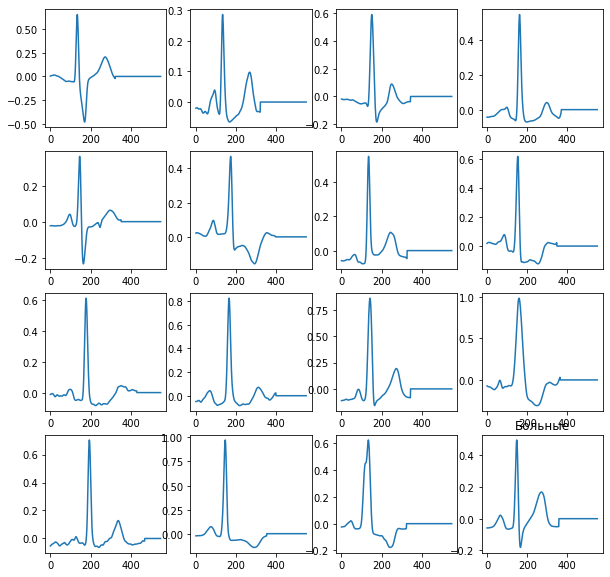

In [26]:
figure, axis = plt.subplots(4, 4, figsize=(10, 10))

for y in range(4):
    for x in range(4):
        axis[y, x].plot(range(len(mi_ecg[y * 4 + x])), mi_ecg[y * 4 + x])  
# Combine all the operations and display
plt.title("Больные")
plt.show();

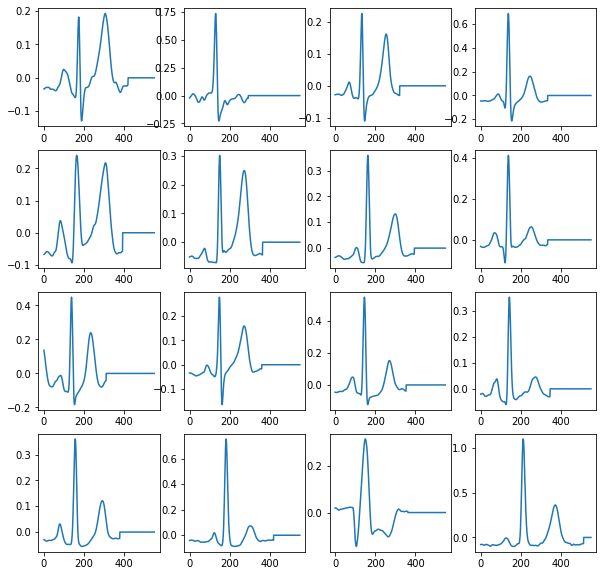

In [27]:
figure, axis = plt.subplots(4, 4, figsize=(10, 10))

for y in range(4):
    for x in range(4):
        axis[y, x].plot(range(len(normal_ecg[y * 4 + x])), normal_ecg[y * 4 + x])  
# Combine all the operations and display
plt.show();

In [28]:
# df_merged["st_std"] = np.mean(hr_array_extr, axis=2)

In [29]:
# from deep_translator import GoogleTranslator

# # Use any translator you like, in this example GoogleTranslator
# translator = GoogleTranslator(source='auto', target='en')  # output -> Weiter so, du bist großartig
# tqdm.pandas()
# df_merged["translatted_report2"] = df_merged["report"].progress_apply(lambda x: translator.translate(x))
# df_merged["translatted_report2"].to_csv("translatted_report2.csv")

In [30]:
df_merged["translatted_report"] = pd.read_csv("reports.csv")["translatted_report"] # .map(lambda x: x.replace(".", ""))
# df_merged["translatted_report"] = pd.read_csv("translatted_report2.csv")["translatted_report2"] # .map(lambda x: x.replace(".", ""))

## working with hr data

# TRAIN

In [31]:
df_prepared = prepare_df(df_merged)

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [32]:
# train_columns = ["myocard"] + ['infarction_stadium1', 'ASMI', 'sbert_6', 'ABQRS', 'IMI', 'sbert_1', 'NORM', 'sbert_0', 'heart_axis', 'AMI', 'age', 'sbert_4', 'sbert_5', 'QWAVE', 'ILMI', 'sbert_14', 'sbert_16', 'validated_by_human', 'sbert_28', 'sbert_21', 'sbert_36', 'sbert_27', 'sbert_18', 'sbert_7', 'sbert_39', 'sbert_2', 'ISCLA', 'sbert_41', 'second_opinion', 'sbert_11', 'nurse', 'sbert_3', 'sbert_9', 'sbert_20', 'sbert_8', 'initial_autogenerated_report', 'sbert_19', 'height', 'validated_by', 'sbert_44', 'NDT', 'LAFB', 'infarction_stadium2', 'sbert_33', 'LOWT', 'sbert_30', 'sbert_22', 'sbert_25', 'weight', 'NT_', 'sbert_24', 'sbert_32', 'group', 'CRBBB', 'sbert_15', 'sbert_38', 'sbert_37', 'sbert_34', 'sbert_45', 'sbert_26', 'sex', '2AVB', 'sbert_47', 'recording_date_norm', 'sbert_49', 'sbert_46', 'sbert_31', 'CLBBB', 'sbert_13', 'sbert_12', 'sbert_10', 'sbert_35', 'device', 'SR', 'sbert_48', 'pacemaker', 'IRBBB', 'sbert_23', 'AFLT', 'AFIB', 'STD_', 'PVC', 'sbert_40', 'sbert_42', 'INVT', '1AVB', 'LAO/LAE', 'sbert_43', 'LVOLT', 'LVH', 'sbert_29', 'IVCD', 'sbert_17', 'ISCAL', 'LMI', 'ISC_', 'VCLVH', 'PAC', 'site', 'PACE', 'LPR', 'WPW', 'SARRH', 'ALMI', 'STACH', 'INJAS', 'HVOLT', 'NST_', 'ILBBB', 'ISCAS', 'LPFB', 'SVTAC', 'RVH', 'ISCIL', 'DIG', 'EL', 'TRIGU', 'TAB_', 'STE_', 'burst_noise', 'INJAL', 'LNGQT', 'BIGU', 'SEHYP', 'ISCAN', 'PRC(S)', 'SVARR', 'electrodes_problems', 'IPLMI', 'ANEUR', '3AVB', 'extra_beats', 'PMI', 'ISCIN', 'RAO/RAE', 'PSVT', 'INJLA', 'IPMI', 'static_noise', 'SBRAD', 'baseline_drift'] 

In [33]:
# train_columns = ["myocard"] + ['infarction_stadium1', 'ASMI', 'sbert_6', 'ABQRS', 'IMI', 'sbert_1', 'NORM', 'sbert_0', 'heart_axis', 'AMI', 'age', 'sbert_4', 'sbert_5', 'QWAVE', 'ILMI', 'sbert_14', 'sbert_16', 'validated_by_human', 'sbert_28', 'sbert_21', 'sbert_36', 'sbert_27', 'sbert_18', 'sbert_7', 'sbert_39', 'sbert_2', 'ISCLA', 'sbert_41', 'second_opinion', 'sbert_11', 'nurse', 'sbert_3', 'sbert_9', 'sbert_20', 'sbert_8', 'initial_autogenerated_report', 'sbert_19', 'height', 'validated_by', 'sbert_44', 'NDT', 'LAFB', 'infarction_stadium2', 'sbert_33', 'LOWT', 'sbert_30', 'sbert_22', 'sbert_25', 'weight', 'NT_', 'sbert_24', 'sbert_32', 'group', 'CRBBB', 'sbert_15', 'sbert_38', 'sbert_37', 'sbert_34', 'sbert_45', 'sbert_26', 'sex', '2AVB', 'sbert_47', 'recording_date_norm', 'sbert_49', 'sbert_46', 'sbert_31', 'CLBBB', 'sbert_13', 'sbert_12', 'sbert_10', 'sbert_35', 'device', 'SR', 'sbert_48', 'pacemaker', 'IRBBB', 'sbert_23', 'AFLT', 'AFIB', 'STD_', 'PVC', 'sbert_40', 'sbert_42', 'INVT', '1AVB', 'LAO/LAE', 'sbert_43', 'LVOLT', 'LVH', 'sbert_29', 'IVCD', 'sbert_17', 'ISCAL', 'LMI', 'ISC_', 'VCLVH', 'PAC', 'site', 'PACE', 'LPR', 'WPW', 'SARRH', 'ALMI', 'STACH', 'INJAS', 'HVOLT', 'NST_', 'ILBBB', 'ISCAS', 'LPFB', 'SVTAC', 'RVH', 'ISCIL', 'DIG', 'EL', 'TRIGU', 'TAB_', 'STE_', 'burst_noise', 'INJAL', 'LNGQT', 'BIGU', 'SEHYP', 'ISCAN', 'PRC(S)', 'SVARR', 'electrodes_problems', 'IPLMI', 'ANEUR', '3AVB', 'extra_beats', 'PMI', 'ISCIN', 'RAO/RAE', 'PSVT', 'INJLA', 'IPMI', 'static_noise', 'SBRAD', 'baseline_drift']

In [34]:
# train_columns = ["myocard"] + ['infarction_stadium1', 'ASMI', 'sbert_6', 'word_infarction', 'word_old', 'IMI', 'word_qrs(t)', 'word_inferior', 'sbert_1', 'word_anteroseptal', 'ABQRS', 'word_normal', 'NORM', 'age', 'sbert_0', 'sbert_4', 'ILMI', 'word_undetermined', 'word_infarction.', 'word_consistent', 'sbert_39', 'word_age', 'sbert_11', 'QWAVE', 'sbert_16', 'sbert_27', 'word_left', 'word_unconfirmed', 'word_position', 'sbert_14', 'word_probable', 'word_sinus', 'word_r', 'heart_axis', 'word_4.46', 'word_waves', 'sbert_5', 'sbert_10', 'sbert_9', 'word_qs', 'sbert_22', 'sbert_20', 'word_tiny', 'sbert_25', 'sbert_8', 'sbert_44', 'sbert_2', 'sbert_21', 'word_report', 'word_type', 'sbert_41', 'word_abnormal', 'word_progression', 'LAFB', 'sex', 'sbert_30', 'word_iii,', 'word_v2', 'sbert_7', 'sbert_24', 'CLBBB', 'word_out', 'word_avf.', 'sbert_33', 'word_ventricular', 'PVC', 'sbert_47', 'sbert_34', 'sbert_12', 'word_rhythm', 'sbert_29', 'sbert_18', 'recording_date_norm', 'word_is', 'nurse', 'sbert_43', 'sbert_28', 'word_shifted', 'AFIB', 'sbert_31', 'word_v', 'word_Edit:', 'word_segment', 'sbert_36', 'word_st', 'sbert_46', 'word_block,', 'NDT', 'word_voltage', 'word_widening', 'word_anterolateral', 'word_damage', 'SR', 'word_a', 'LMI', 'word_with', 'word_sine', 'word_delay.', 'word_myocardial', 'word_be', 'LVH', 'sbert_3', 'word_hypertrophy.', 'word_avf,', 'word_trace', 'word_branch', 'sbert_13', 'word_no', 'TAB_', 'word_to', 'word_flat', 'word_strain.', 'word_t', 'word_but', 'validated_by', 'word_limb', 'NST_', 'word_right', 'sbert_17', 'word_ischaemia', 'word_bundle', 'word_difficult', 'sbert_19', 'word_fibrillation', 'sbert_15', 'word_deviation.', 'word_ruled', 'word_p-sinistrocardial', 'word_infarct', 'sbert_49', 'word_q', 'initial_autogenerated_report', 'word_peripheral', 'strat_fold', 'LVOLT', 'pacemaker', 'word_pathology.', 'AMI', 'word_lvh.', 'word_segments', 'word_elevated', 'word_are', 'IRBBB', 'SVARR', 'word_due', '1AVB', 'word_strain', 'word_ischemia', 'word_(NORM', 'group', 'ISCAL', 'second_opinion', 'sbert_35', 'word_anterior', 'word_hyperextended', 'word_extrasystole(s)', 'LPR', 'word_suggesting', 'word_qt', 'word_definite', 'word_ii,', 'word_ej', 'word_minor', 'word_llt', 'word_this', 'word_depressed', 'word_ECG', 'word_of', 'sbert_48', 'word_bÖr', 'word_v5.6.', 'word_disease.', 'device', 'LPFB', 'word_compared', 'word_T', 'word_qrs', 'word_fÖrlopp', 'word_voltages', 'STD_', 'SBRAD', 'word_ant.', 'NT_', 'word_pr', 'sbert_38', 'word_t-changes', 'word_skÄnkelblock', 'word_80,', 'word_variant.', 'word_block.', 'word_only', 'sbert_23', 'word_at', 'word_i', 'ISC_', 'ALMI', 'word_st-t', 'word_fascicular', 'word_elevation', 'word_cause', 'word_location', 'word_high', 'word_effect', 'word_degree', 'ISCAS', 'sbert_37', 'word_p-sinistrocardiale', 'word_axis', 'height', 'word_15,', 'weight', 'word_bradycardia', 'word_vid', 'VCLVH', 'IVCD', 'word_leads', 'word_complete', 'word_tachycardic', 'word_poor', 'word_determine', 'word_affection', 'RAO/RAE', 'word_intraventricular', 'word_disease', 'SVTAC', 'word_infarkt', 'sbert_26', 'word_uncertain', 'word_v5,6.', 'word_arrhythmia.', 'word_transition', 'word_possible', 'CRBBB', 'word_limit.', 'sbert_42', 'word_digitalis', 'word_avl,', 'word_the', 'PACE', 'word_premature', 'word_voltage.', 'word_lv', 'word_fibrillation/flutter', 'word_v2-6.', 'PAC', 'word_arrhythmia', 'AFLT', 'word_effect.', 'word_likely.', 'word_wave', 'word_nonspecific', 'word_-', 'word_med', 'word_tachycardia.', 'word_criteria', 'word_acute', 'word_evidence', 'word_evident.', 'LOWT', 'burst_noise', 'word_inferolateral', 'word_v1-3', 'infarction_stadium2', 'word_vÄnster', 'word_hyperexcited', 'word_prolongation', 'TRIGU', 'word_NORM', 'word_twisted', 'word_upper', 'word_avl', 'word_discrete', 'word_sÅsom', 'INJLA', 'RVH', '2AVB', 'word_suggest', 'SEHYP', 'word_complexes', 'word_tracing', 'word_path.', 'ILBBB', 'word_overload', 'word_regular', 'word_Ålder', 'word_r-s', 'word_low', 'word_excluded.', 'word_in', 'word_block', 'word_over', 'word_or', 'INJAL', 'DIG', 'word_LVH', 'word_disturbance.', 'EL', 'word_unspecific', 'word_ischemic', 'word_lead', 'word_these', 'word_qt,', 'word_AV', 'word_ECG.', 'word_incomplete', 'word_bifascicular', 'ANEUR', 'word_slightly', 'word_inversion', 'word_p', 'word_v1', 'word_septal', 'word_disorder', 'IPLMI', 'word_otherwise', 'word_ecg', 'WPW', 'HVOLT', 'word_atrial', 'word_conduction', 'word_v2.3', 'word_extreme', 'word_v3-6.', 'LNGQT', 'word_Atrial', 'word_most', 'word_changes.', 'word_bradycardia.', 'word_i,', 'word_ekg', 'word_unspecified', 'word_and', 'word_lateral', 'validated_by_human', 'PRC(S)', 'word_not', 'word_drug', 'IPMI', 'word_enlargement.', 'word_v3', 'word_supraventricular', 'word_100)', 'word_tension', 'word_v4,5,6.', 'word_v4', 'word_tachycardia', 'word_t-fÖrÄndring,', 'word_requested.', 'word_uncertain.', 'word_sÄnkning,', 'word_suspected', 'word_v2.3.', 'word_rapid', 'word_sinusrytm', 'word_v2,3,4', 'word_rhythm.', 'word_response.', 'word_v6.', 'word_depression', 'word_prolonged', 'sbert_45', 'static_noise', 'word_&', 'word_100,', 'word_50,', 'word_Sinus', 'word_Sokolow', 'word_a-v', 'word_abnormal,', 'word_age.', 'word_amplitude', 'word_an', 'word_av', 'word_avf', 'word_avl.', 'word_avvikande', 'word_belastning', 'word_borderline', 'site', 'sbert_40', 'word_changes', 'sbert_32', '3AVB', 'BIGU', 'INJAS', 'INVT', 'ISCAN', 'ISCIL', 'ISCIN', 'ISCLA', 'LAO/LAE', 'PMI', 'PSVT', 'SARRH', 'STACH', 'STE_', 'baseline_drift', 'electrodes_problems', 'extra_beats', 'word_cannot', 'word_chest', 'word_probably', 'word_intraventr.', 'word_ischemi', 'word_ischemia.', 'word_it', 'word_kammarhypertrofi', 'word_leads.', 'word_likely', 'word_limit', 'word_may', 'word_moderate', 'word_neg', 'word_non-specific', 'word_normal.', 'word_old.', 'word_p-widening', 'word_pacemaker', 'word_pathological', 'word_possible.', 'word_inverted', 'word_interval.', 'word_commonly', 'word_infarct.', 'word_contraction(s).', 'word_el-axel', 'word_electrolyte', 'word_eller', 'word_excessive', 'word_exclude', 'word_extrasystole(s),', 'word_fibrillation.', 'word_findings', 'word_flattening', 'word_for', 'word_heart', 'word_hemiblock', 'word_hypertrophy', 'word_hypokalemia.', 'word_hÖg', 'word_iii', 'word_ÖvervÄgas']

In [35]:
# train_columns = df_prepared.columns.to_list() 

In [36]:
# 80!!!! 
# train_columns = ["myocard"] + ['infarction_stadium1', 'ASMI', 'IMI', 'word_infarction', 'word_old', 'word_qrs(t)', 'word_anteroseptal', 'word_inferior', 'hr_max_1', 'word_normal', 'hr_max_9', 'word_undetermined', 'NORM', 'ABQRS', 'hr_max_8', 'hr_min_2', 'hr_std_1', 'hr_max_5', 'word_complexes', 'age', 'hr_min_6', 'hr_median_1', 'word_age', 'hr_max_4', 'hr_std_3', 'hr_min_5', 'QWAVE', 'hr_std_6', 'hr_median_9', 'hr_median_5', 'word_left', 'ILMI', 'word_consistent', 'word_with', 'hr_std_4', 'word_abnormal', 'hr_min_8', 'hr_min_11', 'word_r', 'hr_median_10', 'word_qs', 'hr_median_8', 'hr_max_2', 'word_q', 'word_vÄnster', 'hr_median_3', 'word_waves', 'hr_std_2', 'hr_mean_0', 'word_myocardial', 'hr_max_6', 'word_in', 'hr_min_3', 'hr_min_10', 'word_infarction.', 'word_ii,', 'word_report', 'word_iii,', 'word_progression', 'initial_autogenerated_report', 'word_probable', 'hr_std_11', 'word_v2', 'hr_median_6', 'hr_std_9', 'hr_min_4', 'hr_mean_2', 'hr_min_0', 'STD_', 'word_position', 'word_flat', 'word_avvikande', 'second_opinion', 'word_age.', 'word_rhythm', 'hr_max_7', 'hr_median_7', 'word_avf', 'ALMI', 'hr_max_10', 'hr_median_2', 'hr_mean_11', 'hr_mean_5', 'sex', 'hr_mean_4', 'word_anterior', 'word_atrial', 'validated_by_human', 'hr_min_7', 'hr_std_5', 'word_infarct.', 'word_sinus', 'AMI', 'word_low', 'hr_max_0', 'hr_std_7', 'word_type', 'word_damage', 'word_voltage', 'hr_median_11', 'hr_mean_3', 'height', 'word_fibrillation/flutter', 'word_tachycardia', 'word_pathological', 'word_4.46', 'hr_std_8', 'word_cannot', 'hr_min_1', 'LMI', 'CLBBB', 'hr_mean_9', 'word_but', 'word_i', 'word_enlargement.', 'word_axis', 'word_a-v', 'word_neg', 'hr_mean_1', 'recording_date_norm', 'word_out', 'word_and', 'hr_median_4', 'LPFB', 'word_segment', 'word_bradycardia', 'word_inferolateral', 'IVCD', 'word_depression', 'word_no', 'word_st', 'word_borderline', 'pacemaker', 'word_deviation.', 'word_ruled', 'group', 'word_sine', 'VCLVH', 'NST_', 'word_segments', 'word_to', 'hr_std_0', 'word_infarct', 'word_t', 'word_hemiblock', 'word_qrs', 'word_ischemia.', 'word_ekg', 'word_fibrillation', 'SBRAD', 'word_only', 'word_avf.', 'word_p-sinistrocardiale', 'word_bundle', 'word_the', 'NT_', 'word_avl.', 'word_elevation', 'word_lvh.', 'CRBBB', 'word_pr', 'word_i,', 'word_determine', 'heart_axis', 'strat_fold', 'word_requested.', 'word_hypertrophy.', 'word_tiny', 'hr_median_0', 'word_sinusrytm', 'word_&', 'word_twisted', 'hr_mean_8', 'hr_mean_6', 'hr_min_9', 'word_avl,', 'INVT', 'hr_mean_10', 'word_tachycardia.', 'word_right', 'hr_max_3', 'word_fibrillation.', 'word_v1-3', 'word_hyperexcited', 'word_definite', 'word_avl', 'word_ventricular', 'word_variant.', 'LNGQT', 'word_v6.', 'word_septal', 'word_high', 'word_r-s', 'word_supraventricular', 'word_voltage.', 'SR', 'word_trace', 'word_rhythm.', 'word_difficult', 'word_skÄnkelblock', '1AVB', 'word_p-sinistrocardial', 'word_Edit:', 'word_Atrial', 'word_v5.6.', 'word_lead', 'word_degree', 'word_excessive', 'word_for', 'LVH', 'word_ischemic', 'word_upper', 'word_ecg', 'hr_max_11', 'word_compared', 'word_block', 'word_chest', 'word_med', 'word_fascicular', 'word_delay.', 'word_overload', 'word_unspecific', 'word_conduction', 'word_kammarhypertrofi', 'word_flattening', 'SVARR', 'word_branch', 'word_at', 'word_v5,6.', 'NDT', 'electrodes_problems', 'word_contraction(s).', 'word_inversion', 'word_heart', 'word_criteria', 'word_intraventr.', 'INJAS', 'word_depressed', 'word_otherwise', 'word_prolonged', 'word_peripheral', 'word_ischemia', 'word_sÄnkning,', 'word_eller', 'word_prolongation', 'word_path.', 'ISCAN', 'word_evidence', 'word_p-widening', 'word_block.', 'word_lv', 'IRBBB', 'hr_mean_7', 'word_Ålder', 'word_st-t', 'word_suspected', 'word_Sinus', 'word_ischaemia', 'word_T', 'HVOLT', 'LAFB', 'word_extrasystole(s)', 'LAO/LAE', 'word_limit', 'word_likely', 'word_NORM', 'word_arrhythmia', 'word_v2-6.', 'word_v4,5,6.', 'weight', 'word_uncertain', 'word_location', 'word_v3', 'word_ischemi', 'word_premature', 'PACE', 'word_incomplete', 'INJAL', 'word_are', 'LPR', 'word_it', 'validated_by', 'word_ECG', 'word_anterolateral', 'ISCIN', 'word_v2,3,4', 'word_100,', 'word_infarkt', 'word_80,', 'word_may', 'word_electrolyte', 'PRC(S)', 'STACH', 'word_t-changes', 'word_discrete', 'TRIGU', '2AVB', 'word_digitalis', 'word_ECG.', 'word_extreme', 'word_most', 'word_unspecified', 'ISCAS', 'word_strain', 'ISCLA', 'word_(NORM', 'site', 'word_old.', 'word_moderate', 'word_ej', 'word_leads', 'word_poor', 'word_excluded.', 'word_bradycardia.', 'RVH', 'word_drug', 'word_ant.', 'word_hÖg', 'word_hypertrophy', 'word_complete', 'PAC', 'word_bifascicular', 'ISC_', 'infarction_stadium2', 'word_tracing', 'word_rapid', 'word_possible', 'word_is', 'word_fÖrlopp', 'AFLT', 'word_these', 'word_interval.', 'word_suggest', 'word_belastning', 'word_or', 'word_disorder', 'TAB_', 'word_elevated', 'word_disease.', 'word_shifted', 'word_acute', 'word_v2.3', 'WPW', 'word_50,', 'word_pathology.', 'word_strain.', 'ANEUR', 'word_Sokolow', 'word_a', 'word_findings', 'word_transition', 'word_likely.', 'word_changes.', 'word_evident.', 'word_of', 'word_disease', 'word_bÖr', 'word_LVH', '3AVB', 'word_sÅsom', 'word_affection', 'word_probably', 'word_slightly', 'word_this', 'word_v2.3.', 'word_v4', 'word_tachycardic', 'BIGU', 'word_cause', 'word_qt,', 'PSVT', 'LVOLT', 'word_ÖvervÄgas', 'word_intraventricular', 'word_AV', 'SEHYP', 'SVTAC', 'word_pacemaker', 'IPLMI', 'word_extrasystole(s),', 'word_vid', 'word_p', 'ILBBB', 'word_15,', 'word_avf,', 'word_v1', 'word_non-specific', 'burst_noise', 'word_regular', 'word_disturbance.', 'word_arrhythmia.', 'word_an', 'DIG', 'word_effect.', 'word_unconfirmed', 'word_be', 'word_v3-6.', 'word_v', 'word_possible.', 'RAO/RAE', 'PMI', 'word_normal.', 'word_100)', 'word_-', 'word_widening', 'word_uncertain.', 'word_limb', 'word_exclude', 'word_response.', 'STE_', 'AFIB', 'word_commonly', 'word_el-axel', 'word_av', 'word_suggesting', 'word_over', 'word_due', 'IPMI', 'word_effect', 'INJLA', 'word_inverted', 'EL', 'SARRH', 'LOWT', 'device', 'extra_beats', 'word_voltages', 'word_nonspecific', 'word_hyperextended', 'word_wave', 'word_qt', 'word_hypokalemia.', 'word_iii', 'word_block,', 'static_noise', 'word_lateral', 'nurse', 'word_abnormal,', 'word_leads.', 'word_t-fÖrÄndring,', 'ISCIL', 'word_tension', 'word_changes', 'hr_std_10', 'word_limit.', 'ISCAL', 'PVC', 'word_llt', 'word_amplitude', 'baseline_drift', 'word_minor', 'word_not']

In [37]:
# train_columns = ["myocard"] + ["infarction_stadium1", "ASMI", "word_infarction", "word_normal", "IMI", "word_qrs(t)", "word_old", "ABQRS", "word_anteroseptal",
#                                "NORM", "heart_axis", "word_abnormal", "hr_min_5", "hr_max_8", "hr_max_4", "hr_max_1", "word_undetermined", "age", "word_sinus",
#                                "hr_max_9", "word_left", "nurse", "word_ii,", "word_complexes", "QWAVE", "hr_min_9", "word_consistent", "word_infarct", "LAFB", # "word_446",
#                                "hr_max_5", "word_inferior", "word_report", "hr_min_10", "hr_max_3", "word_waves", "word_segments", "strat_fold", "word_but", "word_qs", "ILMI"]

In [38]:
train_columns = ["myocard"] + ["infarction_stadium1", "ASMI", "word_infarction", "word_normal", "IMI", "word_qrs(t)", "word_old", "ABQRS", "word_anteroseptal",
                               "NORM", "heart_axis", "word_abnormal", "hr_min_5", "hr_max_8", "hr_max_4", "hr_max_1", "word_undetermined", "age", "word_sinus",
                               "hr_max_9", "word_left", "nurse", "word_ii,", "word_complexes", "QWAVE", "hr_min_9", "word_consistent", "word_infarct", "LAFB", # "word_446",
                               "hr_max_5", "word_inferior", "word_report", "hr_min_10", "hr_max_3", "word_waves", "word_segments", "strat_fold", "word_but", "word_qs", "ILMI"]
train_columns = train_columns + [x for x in df_prepared.columns if x.startswith("wavelet")] # ["wavelet_mns_5_0_5", "wavelet_mds_3_1_1", "wavelet_lee_2_1_9"]

In [39]:
# 'recording_date', 'report', 'scp_codes', 'filename_lr', 'filename_hr', 'record_name', 'translatted_report'

In [40]:
# f"lee_{i}", f"see_{i}",
#                             f"mds_{i}", f"mns"

## catboost + cross-validation

In [41]:
n_splits = 5

MAX_FEATURES = 6000
selected_columns = [x for x in train_columns[:MAX_FEATURES] if x != "myocard"] 
train_df = df_prepared.copy()[train_columns[:MAX_FEATURES]]
cat_features = [x for x in ["device", "heart_axis", "baseline_drift", "static_noise",
                "burst_noise", "electrodes_problems", "extra_beats", "pacemaker",
               "infarction_stadium1", "infarction_stadium2"] if x in train_columns[:MAX_FEATURES]]
for col in cat_features:
    train_df[col] = train_df[col].astype('category')
# 'heart_axis', 'filename_lr', 'filename_hr', 'record_name', 'scp_codes'
# ПОЧТИ ПУСТЫЕ 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'infarction_stadium1', 'infarction_stadium2'

X = train_df.drop(columns=["myocard"])
y = train_df["myocard"]

In [42]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     clf = GradientBoostingClassifier(
#         random_state=42,
#         n_estimators=20
#     )

    clf = CatBoostClassifier(
        depth=6,
        iterations=3500,
        learning_rate=0.06,
        loss_function="MultiClass",  # MultiLogloss MultiClass
        eval_metric="TotalF1:average=Macro",  # 'AUC / Accuracy,
        custom_metric="TotalF1:average=Macro",
        boosting_type="Ordered",
        
        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры скорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=7575,
    #    auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

#     clf.fit(X_train, y_train)

    clf.fit(
        X_train, y_train,

        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=False)

    y_pred = clf.predict(X_test)
    # print(y_pred[:, 1])
    score = f1_score(y_test, y_pred, average="macro")  # np.mean(np.array(y_pred == y_test))
    scores.append(score)
    print(f"\nfold: f1 score: {score} \n")

assert len(clfs) == n_splits
print(
    "mean f1 score ====>>> " + str(np.mean(scores, dtype="float32")) + " <<<====", np.std(scores).round(4), "\n"
)

0:	learn: 0.7714348	test: 0.7281495	best: 0.7281495 (0)	total: 446ms	remaining: 26m
100:	learn: 0.9008590	test: 0.8616237	best: 0.8616237 (97)	total: 22.9s	remaining: 12m 49s
200:	learn: 0.9311179	test: 0.8668500	best: 0.8682091 (197)	total: 45.5s	remaining: 12m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8682091124
bestIteration = 197

Shrink model to first 198 iterations.



fold: f1 score: 0.8682091123822533 

0:	learn: 0.8437883	test: 0.8473837	best: 0.8473837 (0)	total: 248ms	remaining: 14m 27s
100:	learn: 0.8952578	test: 0.8852837	best: 0.8852837 (91)	total: 24.9s	remaining: 13m 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.889788574
bestIteration = 101

Shrink model to first 102 iterations.



fold: f1 score: 0.8897885739991003 

0:	learn: 0.7918212	test: 0.7815818	best: 0.7815818 (0)	total: 239ms	remaining: 13m 57s
100:	learn: 0.8971648	test: 0.8615493	best: 0.8648290 (77)	total: 22.9s	remaining: 12m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8648290485
bestIteration = 77

Shrink model to first 78 iterations.



fold: f1 score: 0.8648290485025178 

0:	learn: 0.7940907	test: 0.8144712	best: 0.8144712 (0)	total: 245ms	remaining: 14m 15s
100:	learn: 0.8909910	test: 0.9001056	best: 0.9001056 (100)	total: 23s	remaining: 12m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9001056026
bestIteration = 100

Shrink model to first 101 iterations.



fold: f1 score: 0.9001056026486286 

0:	learn: 0.8338308	test: 0.8639456	best: 0.8639456 (0)	total: 248ms	remaining: 14m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8791366906
bestIteration = 30

Shrink model to first 31 iterations.



fold: f1 score: 0.8791366906474821 

mean f1 score ====>>> 0.88041383 <<<==== 0.0132 



In [ ]:
# # !pip install xgboost -q
# import xgboost as xgb

# dtrain = xgb.DMatrix(X,
#                      label=y,
#                      nthread=-1,
#                      enable_categorical=True,)

# def f1_eval(predt, dtrain):
#     y = dtrain.get_label()

#     # convert the predicted values from {predt E R | 0<predt<1} to {0, 1} with a threshold of 0.5
#     # all values less than 0.5 would be converted to 0 (False) and
#     # all values equal or greater than 0.5 would be converted to 1 (True)
#     predt_binary = np.where(predt > 0.5, 1, 0)
#     return "F1_score", f1_score(y_true=y, y_pred=predt_binary)

In [ ]:
# print('running cross validation')
# # do cross validation, this will print result out as
# # [iteration]  metric_name:mean_value+std_value
# # std_value is standard deviation of the metric

# params = {
#     'objective': 'binary:logistic',
#     'seed': 42,
#     'booster': 'gbtree',
#     'max_depth': 5,
#     'min_child_weight': 3,
#     'gamma': 0.5
# }

# xgb.cv(params, dtrain, 100, nfold=5,
#        metrics={'error'}, custom_metric=f1_eval, seed=0,
#        callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

['infarction_stadium1', 'ASMI', 'word_infarction', 'word_old', 'IMI', 'word_anteroseptal', 'word_inferior', 'word_normal', 'word_qrs(t)', 'ABQRS', 'hr_max_1', 'hr_max_5', 'wavelet_max_5_0_7', 'wavelet_max_3_1_5', 'wavelet_max_4_0_7', 'age', 'wavelet_max_4_0_3', 'NORM', 'wavelet_mds_5_0_5', 'word_abnormal', 'word_undetermined', 'QWAVE', 'wavelet_max_5_0_11', 'hr_max_4', 'wavelet_min_2_0_6', 'wavelet_max_5_0_3', 'wavelet_max_3_1_9', 'wavelet_mds_2_1_1', 'wavelet_lee_1_1_9', 'hr_max_9', 'wavelet_mds_3_0_11', 'hr_min_5', 'wavelet_mds_4_0_9', 'wavelet_max_3_0_7', 'wavelet_max_4_0_11', 'wavelet_see_4_1_1', 'wavelet_lee_1_1_5', 'wavelet_min_1_0_6', 'wavelet_see_1_1_10', 'hr_max_8', 'wavelet_min_1_0_2', 'ILMI', 'wavelet_lee_2_0_1', 'wavelet_mns_5_0_5', 'word_consistent', 'wavelet_mds_2_1_9', 'wavelet_max_1_0_1', 'wavelet_min_3_1_11', 'wavelet_min_4_0_2', 'wavelet_mds_1_0_5', 'word_left', 'wavelet_lee_5_0_9', 'word_complexes', 'wavelet_mds_3_1_9', 'wavelet_lee_4_0_1', 'wavelet_max_0_1_6', 'wave

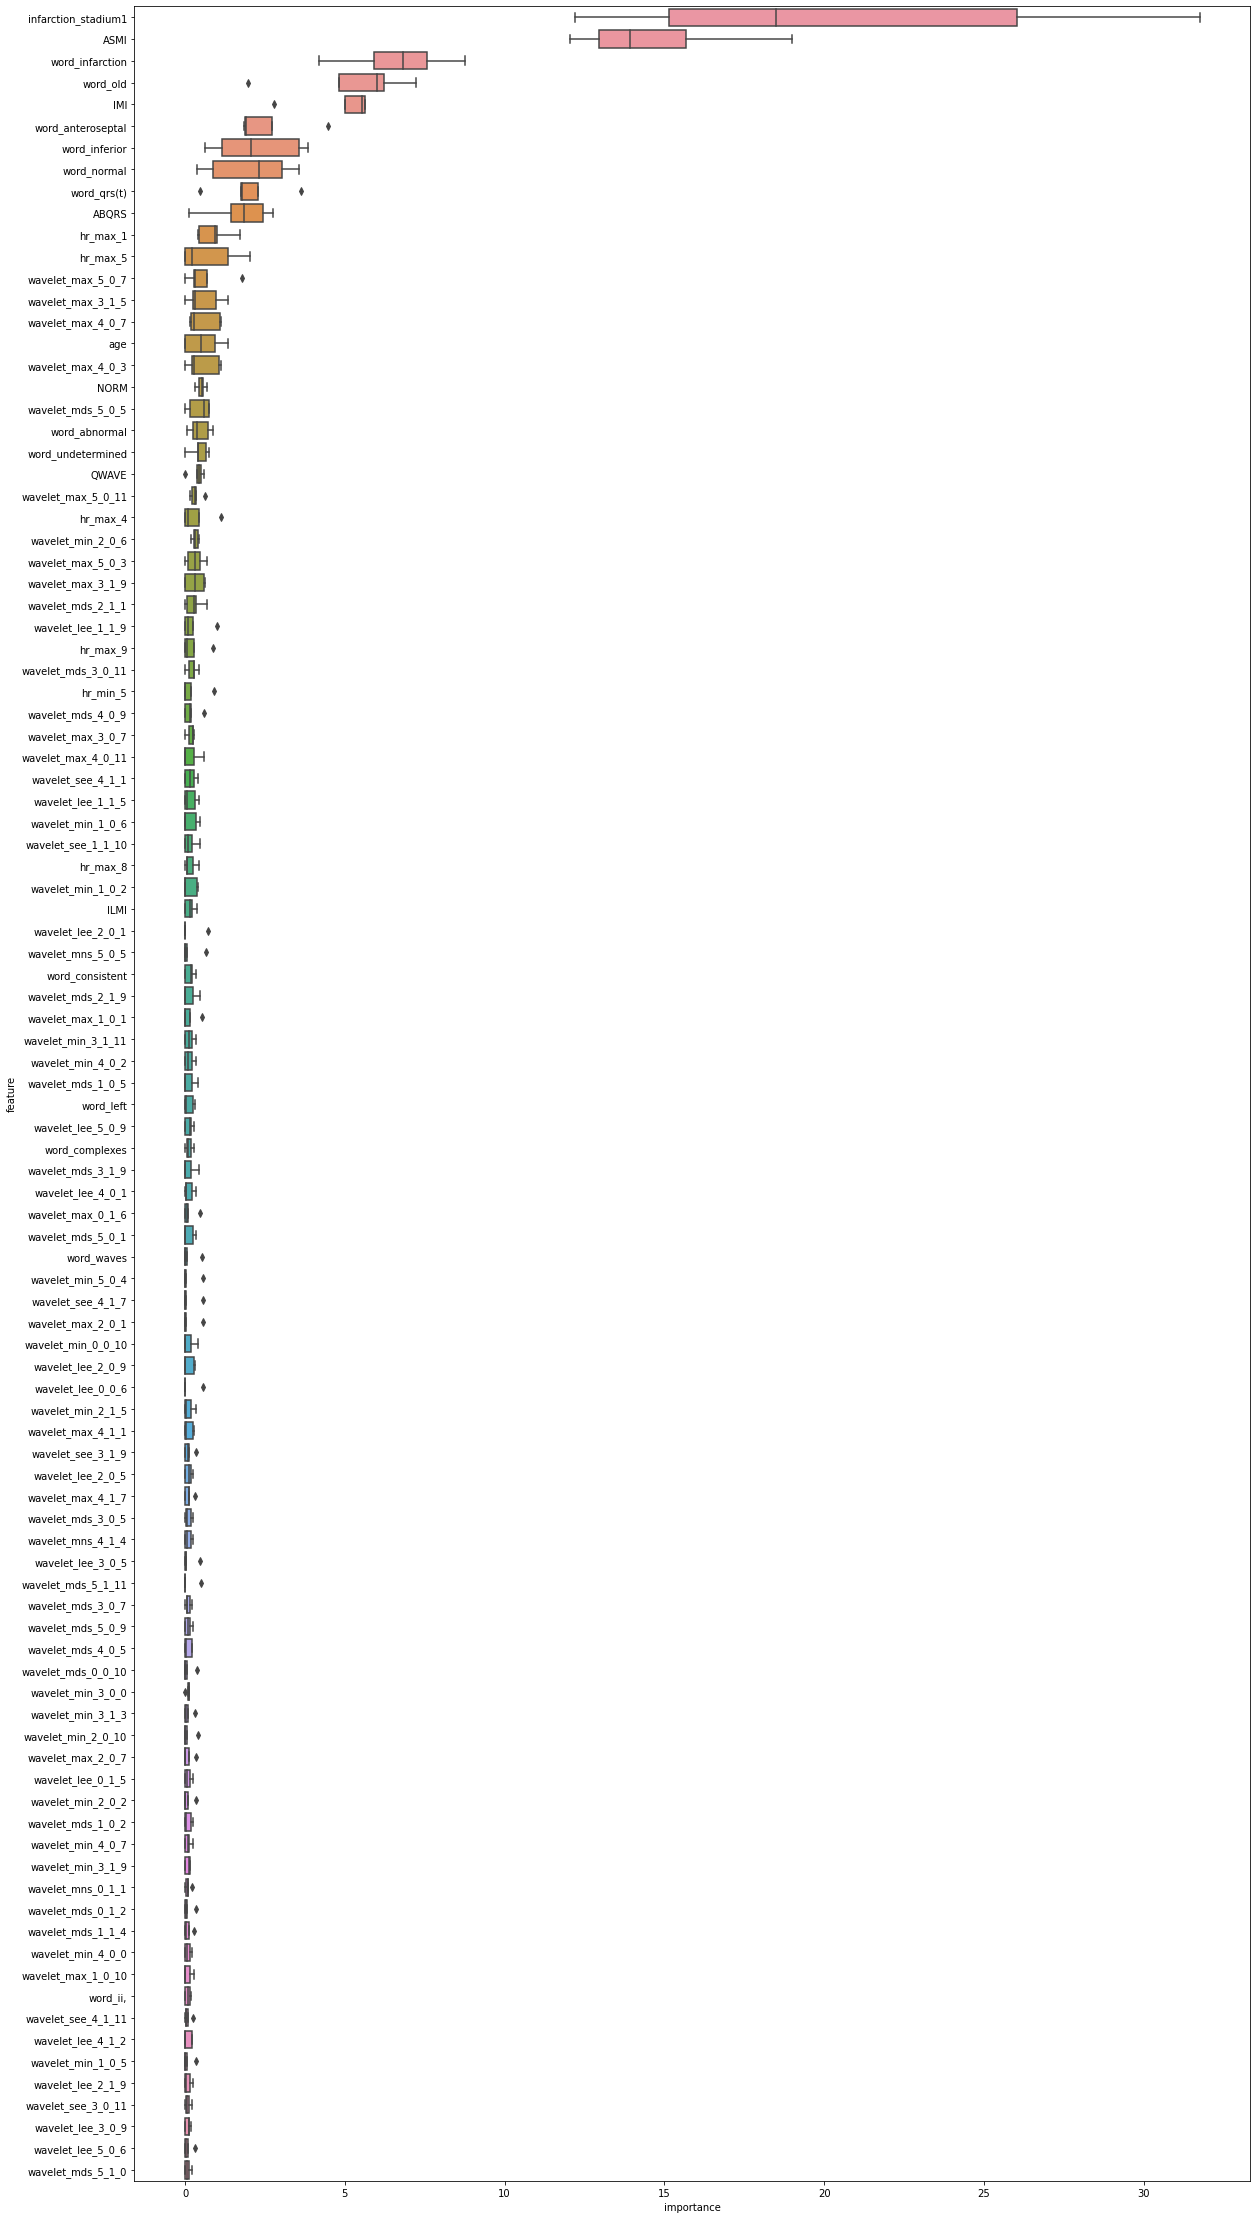

In [43]:
def plot_importance(df, best_model, height, top_n=50):

    top_n = min(top_n, df.shape[1])

    # Извлекаем значения из модели
    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:, [0, 2]]
    fi.columns = ["feature", "importance"]

    # Определяем порядок признаков и отбираем только n признаков для отрисовки
    cols_ord = (
        fi.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    
    print(cols_ord)
    
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]  # Выравниваем порядок по убыванию важности
    print( "Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))

    # Отрисовываем боксплоты фичей
    plt.figure(figsize=(20, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False)
    )


df_feats_imp = plot_importance(
    X, #train[filtered_features].drop(targets, axis=1, errors="ignore"),
    clfs,
    0.40,
    top_n=100,
)

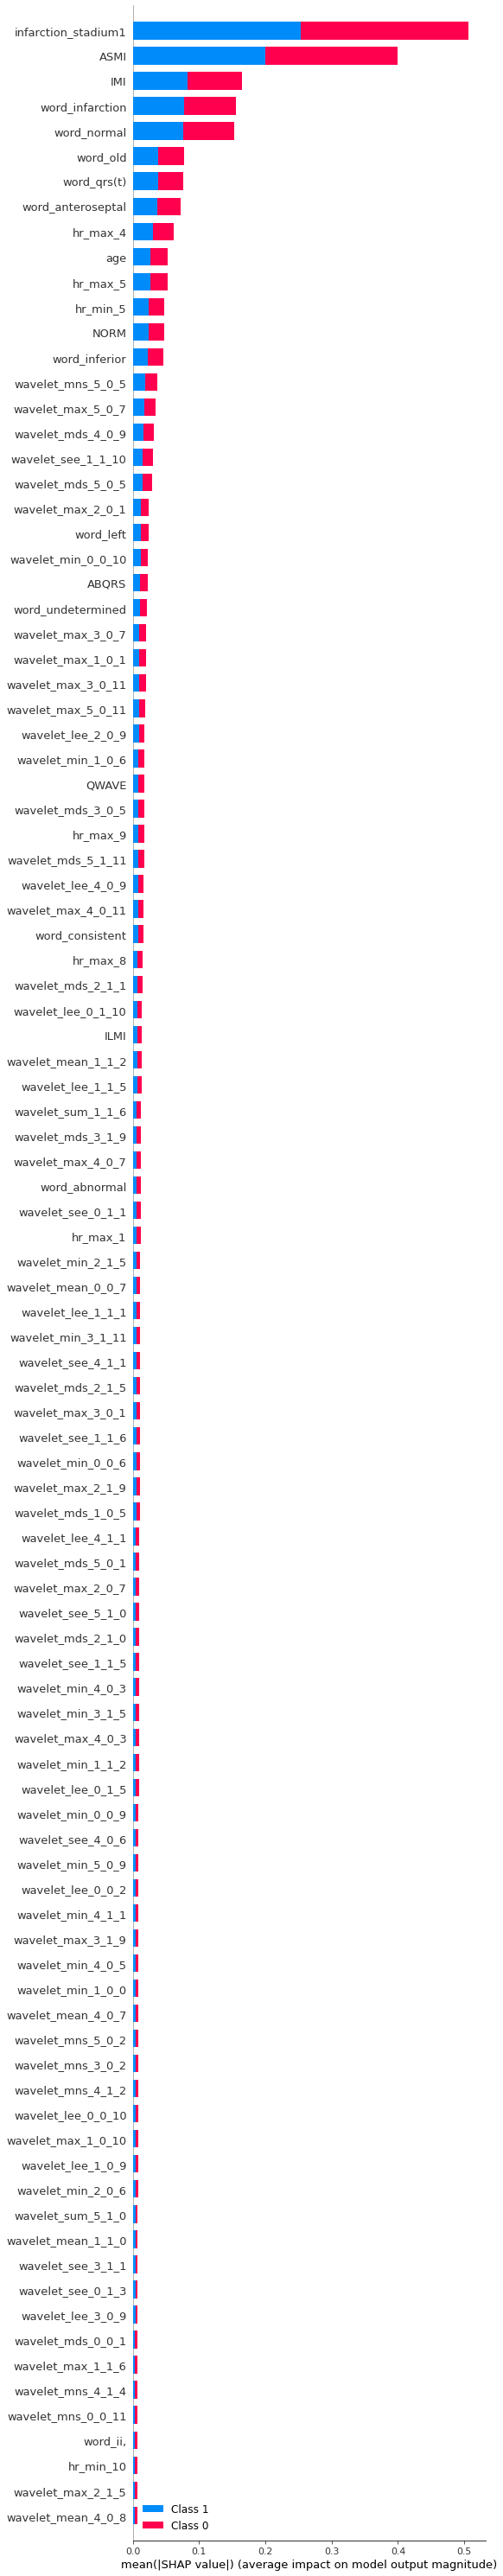

In [44]:
# Посмотрим на SHAP values
import shap
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
explainer = shap.TreeExplainer(clfs[0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=100)

In [45]:
np.abs(shap_values).sum(0).shape

(631, 1192)

In [ ]:
# vals= np.abs(shap_values).sum(0).mean(0)
# feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)), columns=['col_name','feature_importance_vals'])
# feature_importance.sort_values(by=['feature_importance_vals', 'col_name'],ascending=False,inplace=True)
# feature_importance[feature_importance["feature_importance_vals"] > 0].col_name.to_list()

In [ ]:
# summary = clfs[0].select_features(X_train, y_train, 
#                       eval_set=(X_test, y_test),
#                       features_for_select='0-501',
#                       num_features_to_select=100,
#                       steps=1,
#                       train_final_model=False,
#                       logging_level='Verbose')

In [ ]:
# # Посмотрим на список отобранных фичей (не отранжирован по важности)
# print(summary['selected_features_names'])
# # И на лучшее значение лосса
# print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

# make predicts

In [ ]:
test_meta_df = pd.read_csv("task_1/test/test_meta.csv")
sample_df = pd.read_csv("sample.csv")

In [ ]:
test_meta_df

In [ ]:
# from deep_translator import GoogleTranslator

# # Use any translator you like, in this example GoogleTranslator
# translator = GoogleTranslator(source='de', target='en')  # output -> Weiter so, du bist großartig
# tqdm.pandas()
# test_meta_df["translatted_report"] = test_meta_df["report"].progress_apply(lambda x: translator.translate(x))

In [ ]:
test_meta_df["translatted_report"] = pd.read_csv("reports_test.csv")["translatted_report"]

In [ ]:
test_prepared_df = prepare_df(test_meta_df, is_train=False)

In [ ]:
test_prepared_df.columns

In [ ]:
# массив для записи финального прогноза size*n_class
test_data = test_prepared_df.copy()
X_test = test_data[selected_columns]
y_pred = np.zeros((X_test.shape[0], df_prepared["myocard"].nunique()))

# Используем все модели из списка clfs для инференса
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(X_test)

test_df = pd.DataFrame()
test_df["record_name"] = test_meta_df["record_name"]

f = lambda x: clf.classes_[x]
test_df["myocard"] = list(map(f, y_pred.argmax(axis=1)))
test_df.to_csv("submit.csv", index=False)
test_df

In [ ]:
total_df = sample_df.merge(test_df, on="record_name", suffixes=("_x", ""))
total_df[["record_name", "myocard"]].to_csv("submit.csv", index=False)
total_df

In [ ]:
test_with_preds = test_meta_df.merge(total_df[["record_name", "myocard"]], on="record_name")
test_preds_df = prepare_df(test_with_preds, is_train=False)

In [ ]:
test_preds_df[[x for x in test_preds_df.columns.to_list() if x.endswith("MI")] + ["NORM"]].info()

In [ ]:
test_preds_df[test_preds_df.NORM.isin([100])]["myocard"].value_counts()

In [ ]:
[x for x in test_preds_df.columns.to_list() if x.endswith("MI")]

In [ ]:
probs = [100]

In [ ]:
test_preds_df.loc[test_preds_df["AMI"].isin(probs) | (test_preds_df["IPMI"].isin(probs)) |
              test_preds_df["LMI"].isin(probs) | (test_preds_df["IPLMI"].isin(probs)) |
              test_preds_df["ILMI"].isin(probs) | (test_preds_df["IMI"].isin(probs)) |
              test_preds_df["PMI"].isin(probs) | (test_preds_df["ASMI"].isin(probs)) |
              test_preds_df["ALMI"].isin(probs), "myocard"] = 1

In [ ]:
total_df = sample_df.merge(test_preds_df, on="record_name", suffixes=("_x", ""))
total_df[["record_name", "myocard"]].to_csv("submit.csv", index=False)
total_df

In [ ]:
# PUBLIC LB
# 0.88328713 -- 0.8846584885658033
# 0.887352   -- 0.8955102040816327

# PyTorch

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
from imblearn.over_sampling import SMOTE 

In [ ]:
def open_hr_data(filenames, is_train=True):
    total_data = []
    for filename in tqdm(filenames):
        filename = filename.split("/")[-1]
        with open(f"task_1/{'train' if is_train else 'test'}_extr/{filename}.npy", "rb") as f:
            data = np.load(f, allow_pickle=True)
        stats = []
        total_data.append(data)
    return total_data

In [ ]:
hr_opened = open_hr_data(df_merged["filename_hr"].to_list(), is_train=True)

In [ ]:
X = np.array(hr_opened)
y = df_merged["myocard"]

In [ ]:
X.shape

In [ ]:
# sm = SMOTE(random_state=42)
# X_extended, y_extended = sm.fit_resample(X, y)
# print(f'''Размер выборки до применения SWOTE: {X.shape}
# Размер после SMOTE: {X_extended.shape}''')

In [ ]:
X = torch.Tensor(X).float()
y = torch.Tensor(y).long()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=8)

In [ ]:
class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels, 
            out_channels=self.out_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride, 
            groups=self.groups)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.conv(net)

        return net
        
class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.max_pool(net)
        
        return net
    
class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups, downsample, use_bn, use_do, is_first_block=False):
        super(BasicBlock, self).__init__()
        
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=1,
            groups=self.groups)
                
        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):
        
        identity = x
        
        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)
        
        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)
        
        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)
            
        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)
        
        # shortcut
        out += identity

        return out
    
class ResNet1D(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes
        
    """

    def __init__(self, in_channels, base_filters, kernel_size, stride, groups, n_block, n_classes, downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False):
        super(ResNet1D, self).__init__()
        
        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap # 2 for base model
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(in_channels=in_channels, out_channels=base_filters, kernel_size=self.kernel_size, stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters
                
        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels
            
            tmp_block = BasicBlock(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=self.kernel_size, 
                stride = self.stride, 
                groups = self.groups, 
                downsample=downsample, 
                use_bn = self.use_bn, 
                use_do = self.use_do, 
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        out = x
        
        # first conv
        if self.verbose:
            print('input shape', out.shape)
        out = self.first_block_conv(out)
        if self.verbose:
            print('after first conv', out.shape)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)
        
        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            if self.verbose:
                print('i_block: {0}, in_channels: {1}, out_channels: {2}, downsample: {3}'.format(i_block, net.in_channels, net.out_channels, net.downsample))
            out = net(out)
            if self.verbose:
                print(out.shape)

        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)
        if self.verbose:
            print('final pooling', out.shape)
        # out = self.do(out)
        out = self.dense(out)
        if self.verbose:
            print('dense', out.shape)
        # out = self.softmax(out)
        if self.verbose:
            print('softmax', out.shape)
        
        return out    

In [ ]:
# model = TransformerModel(
#     d_model=64, nhead=4, dim_feedforward=256, 
#     nlayers=4, n_conv_layers=2, n_class=2, 
#     dropout=0.5, dropout_other=0.1
# ).to(device)
# model = TinyModel()
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"
print(f"Using {device} device")

kernel_size = 16
stride = 2
n_block = 12
downsample_gap = 6
increasefilter_gap = 12
model = ResNet1D(
        in_channels=1, 
        base_filters=32, # 64 for ResNet1D, 352 for ResNeXt1D
        kernel_size=kernel_size, 
        stride=stride, 
        groups=32, 
        n_block=n_block, 
        n_classes=2, 
        downsample_gap=downsample_gap, 
        increasefilter_gap=increasefilter_gap, 
        use_do=True)
model = model.to(device)

# print(model)

In [ ]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X)
        # print(pred.shape, y.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            y_pred.extend(pred.argmax(1).tolist())
            y_true.extend(y.tolist())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n F1: {f1_score(y_true, y_pred, average='macro'):>8f}%, Avg loss: {test_loss:>8f} \n")
    
    return 

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

In [ ]:
def predict_loop(dataloader, model):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    predicts = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            pred = model(X)
            predicts.extend(pred.argmax(1).tolist())
    return predicts

In [ ]:
whole_dataset = TensorDataset(X, y)
whole_dataloader = DataLoader(whole_dataset, batch_size=8)
predicts = predict_loop(whole_dataloader, model)
predicts_ready = True
predicts